In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point
import sys
import os
import statistics
import psutil
import copy
import pickle
import re
from abc import ABC, abstractmethod
import math
import copy
import xml.etree.ElementTree as ET
import gc
from copy import deepcopy
from pathlib import Path
from skimage import data
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import skimage
import PIL
from skimage.filters import threshold_otsu
import torchvision.models as torchmodels
import openslide
import torch.utils.data
import torchvision
import torch.nn as nn
list_pathstoadd = ["../../", "../../../PyDmed/"]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import pydmed
from pydmed.utils.data import *
import pydmed.lightdl
from pydmed.lightdl import *
import pydmed.stat
from pydmed.stat import *
import relatedwork
from relatedwork.utils.generativemodels import ResidualEncoder
import bovw_pipeline
from bovw_pipeline import *
import localsrc_samplenotebooks
from localsrc_samplenotebooks import *

In [2]:
#SETTINGS ================
flag_use_annotregions = False
npseed = 15
num_visualwords = 10
batchsize = 64
stepsize_gradupdate = 20
num_warmup_droppedpatches = 400
#debugflags =====
flag_verbose_perwsiavg = False
num_trainingepochs = 5
dataset_flags = {
    "load_image":True,\
    "load_er_percentage":False,\
    "load_er_intensity":False,\
    "load_pr_percentage":False,\
    "load_pr_intensity":False,\
    "typeof_label":"discrete" #[discrete:threshold on 25.5][continuous:i.e. regression]
}
learning_params = {
    "split_percentages":[50.0, 10.0, 40.0]
}
def custom_Y_axis(netout):
    temp = scipy.special.softmax(netout, axis=1)
    return temp[:,1], "custom"
def callback_getlabel(recscore):
    if(not isinstance(recscore,int)):
        if(recscore in ["Na", "NA"]):
            return 25.5
        else:
            recscore = int(recscore)
    if(recscore < 25.5):
        return 0
    else:
        return 1
    
nb_rootdir = "./"
np.random.seed(npseed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Make Datasets (train/val/test)

In [4]:
#build datasets ==============================================
rootdir = "/media/user1/9894F11594F0F69A/Ak/Data/CCI_RecurrenceScore/"
def func_get_patientrecords(file_name):
    #remove the parent directory from the file-name ==========
    if("/" in file_name):
        indicesof_slashes = [u.start() for u in re.finditer("/", file_name)]
        raw_file_name = file_name[indicesof_slashes[-1]+1::]
    else:
        raw_file_name = file_name
    #given the raw-file-name, build dict_records (excluding the wsi) =========
    #read the csv file
    fname_csvfile = \
        "/media/user1/9894F11594F0F69A/Ak/Data/CCI_RecurrenceScore/recscore_labels.csv"
    with open(fname_csvfile) as f:
        lis = [line for line in f] 
        for line in lis:
            casename, rs, er_pr, er_in, pr_pr, pr_in = line.split(',')
            if(casename in raw_file_name):
                
                print("casename={}   found in {}".format(casename, raw_file_name))
                dict_toret = {"casename":casename,\
                              "rs":rs,\
                              "er_pr":er_pr,\
                              "er_in":er_in,\
                              "pr_pr":pr_pr,\
                              "pr_in":pr_in,\
                              "list_polygons":None
                            }
                #add the annotation polygon to dict_toret ========
                dir_annotations = "/media/user1/9894F11594F0F69A/Ak/Data/" +\
                                  "CCI_RecurrenceScore/Annotations_20.07.10/"
                flag_xmlfound = False
                for fname_xml_temp in os.listdir(dir_annotations):
                    if(casename in fname_xml_temp):
                        print("  casename={}   found in {}".format(casename, fname_xml_temp))
                        flag_xmlfound = True
                        fname_xml = fname_xml_temp
                        break
                if(flag_xmlfound == True):
                    tree = ET.parse(dir_annotations + fname_xml)
                    root = tree.getroot()
                    root[0][0][0]
                    list_polygons = []
                    for annotation in root[0]:
                        list_polygpoints = []
                        print(annotation)
                        list_coordinates = annotation[0]
                        for coordinate in list_coordinates:
                            order = coordinate.get("Order")
                            X = coordinate.get("X")
                            Y = coordinate.get("Y")
                            print("order={}, X,Y = [{} , {}]"
                                  .format(order, X, Y))
                            list_polygpoints.append([float(X) , float(Y)])
                    list_polygons.append(list_polygpoints)
                    print("list polygons:")
                    print(list_polygons)
                    print("\n\n\n")
                    dict_toret["list_polygons"] = list_polygons
                return dict_toret   
def func_get_wsiinfos(fname):
    return {"resolution":"40x"}
    
recscore_dataset = Dataset.create_onetoone(str_dsname="Edmonton-CCI",\
                                           rootdir=rootdir,\
                                           imgsprefix="svs",\
                                           func_get_patientrecords=func_get_patientrecords,\
                                           func_get_wsiinfos=func_get_wsiinfos)
for pat in recscore_dataset.list_patients:
    try:
        temp = int(pat.dict_records["rs"])
    except:
        recscore_dataset.list_patients.remove(pat)
        print("Patient {} with recscore {} removed from dataset."\
              .format(pat.int_uniqueid, pat.dict_records["rs"]))
train_ds, val_ds, test_ds = Dataset.splits_from(recscore_dataset, \
                                                percentage_partitions=[50,10,40])

casename=104950453   found in 104950453.svs
  casename=104950453   found in 104950453.xml
<Element 'Annotation' at 0x7f928030e830>
order=0, X,Y = [28406.8906 , 16347.9473]
order=1, X,Y = [20574.793 , 13364.291]
order=2, X,Y = [16472.2656 , 10131.998]
order=3, X,Y = [9075.28613 , 10380.6357]
order=4, X,Y = [5656.51416 , 12431.8994]
order=5, X,Y = [4848.44043 , 17342.5]
order=6, X,Y = [5905.15186 , 22439.5781]
order=7, X,Y = [6961.86328 , 27101.5391]
order=8, X,Y = [9199.60547 , 31763.502]
order=9, X,Y = [11126.5498 , 35368.7539]
order=10, X,Y = [17964.0938 , 35493.0703]
order=11, X,Y = [17964.0938 , 29152.8027]
order=12, X,Y = [21134.2285 , 25734.0312]
order=13, X,Y = [22874.6934 , 22812.5352]
order=14, X,Y = [24863.7988 , 20326.1543]
<Element 'Annotation' at 0x7f9280368350>
order=0, X,Y = [50473.5117 , 39844.2344]
order=1, X,Y = [50162.7109 , 47862.8125]
order=2, X,Y = [56440.8203 , 51468.0625]
order=3, X,Y = [56440.8203 , 48795.2031]
order=4, X,Y = [58119.1289 , 47365.5352]
order=5, X

casename=HR19-2726   found in HR19-2726;1;)1D MH19-9543;1.svs
  casename=HR19-2726   found in HR19-2726;1;)1D MH19-9543;1.xml
<Element 'Annotation' at 0x7f928030e830>
order=0, X,Y = [21196.7773 , 33885.7578]
order=1, X,Y = [26686.8516 , 37085.2734]
order=2, X,Y = [31667.9141 , 33194.9531]
order=3, X,Y = [36030.8867 , 25741.541]
order=4, X,Y = [36939.8398 , 18397.2031]
order=5, X,Y = [35049.2188 , 13197.9941]
order=6, X,Y = [29013.7715 , 11416.4463]
order=7, X,Y = [23887.2773 , 12070.8926]
order=8, X,Y = [16542.9395 , 10616.5684]
order=9, X,Y = [14506.8857 , 10471.1357]
order=10, X,Y = [14143.3047 , 17342.8184]
order=11, X,Y = [14434.1689 , 24141.7852]
order=12, X,Y = [14943.1826 , 29995.4395]
<Element 'Annotation' at 0x7f927e860290>
order=0, X,Y = [50646.8477 , 8944.09473]
order=1, X,Y = [45702.1445 , 6544.45947]
order=2, X,Y = [41193.7383 , 6108.1626]
order=3, X,Y = [38866.8203 , 10143.9121]
order=4, X,Y = [40212.0703 , 12579.9062]
order=5, X,Y = [42248.125 , 16652.0137]
order=6, X,Y 

casename=HR19-522   found in HR19-522;1;)A8 S19-1015;1.svs
  casename=HR19-522   found in HR19-522;1;)A8 S19-1015;1.xml
<Element 'Annotation' at 0x7f927e860ad0>
order=0, X,Y = [24255.0703 , 28535.377]
order=1, X,Y = [21106.3398 , 28584.5762]
order=2, X,Y = [16924.4297 , 28043.3887]
order=3, X,Y = [14562.8818 , 29568.5547]
order=4, X,Y = [13628.1025 , 31290.5176]
order=5, X,Y = [13677.3018 , 32668.0879]
order=6, X,Y = [10774.5645 , 33701.2656]
order=7, X,Y = [9839.78516 , 36161.2109]
order=8, X,Y = [11118.957 , 39113.1445]
order=9, X,Y = [10676.167 , 40441.5156]
order=10, X,Y = [11601.3311 , 44167.2695]
order=11, X,Y = [15346.6426 , 45080.7617]
order=12, X,Y = [18406.8359 , 43847.5508]
order=13, X,Y = [20233.8164 , 45583.1797]
order=14, X,Y = [21649.7266 , 48506.3516]
order=15, X,Y = [24207.5 , 52068.9648]
order=16, X,Y = [27404.7188 , 51155.4727]
order=17, X,Y = [30282.2129 , 46633.6953]
order=18, X,Y = [29049.002 , 44075.9219]
order=19, X,Y = [25623.4121 , 42203.2656]
order=20, X,Y = 

order=3, X,Y = [33148.1445 , 20758.3477]
order=4, X,Y = [33528.5352 , 17769.5801]
order=5, X,Y = [32170.0039 , 16465.3906]
order=6, X,Y = [30648.4492 , 17117.4844]
order=7, X,Y = [29942.0137 , 19073.7695]
order=8, X,Y = [29561.625 , 21301.7598]
order=9, X,Y = [27224.9531 , 21410.4414]
order=10, X,Y = [28311.7773 , 24725.2559]
order=11, X,Y = [30050.6953 , 27496.6582]
order=12, X,Y = [29507.2832 , 31191.8613]
order=13, X,Y = [31191.8613 , 32604.7324]
order=14, X,Y = [34452.3359 , 33474.1914]
list polygons:
[[[33691.5586, 31028.8359], [32387.3691, 24996.9629], [31137.5195, 22660.2891], [33148.1445, 20758.3477], [33528.5352, 17769.5801], [32170.0039, 16465.3906], [30648.4492, 17117.4844], [29942.0137, 19073.7695], [29561.625, 21301.7598], [27224.9531, 21410.4414], [28311.7773, 24725.2559], [30050.6953, 27496.6582], [29507.2832, 31191.8613], [31191.8613, 32604.7324], [34452.3359, 33474.1914]]]




casename=HR16-2069   found in HR16-2069;1;)A2 S16-2180;1.svs
  casename=HR16-2069   found in 

casename=HR16-2683   found in HR16-2683;1;)1E MH16-12080;1.svs
  casename=HR16-2683   found in HR16-2683;1;)1E MH16-12080;1.xml
<Element 'Annotation' at 0x7f928030ec50>
order=0, X,Y = [33131.2422 , 6748.95605]
order=1, X,Y = [4478.85254 , 2883.64478]
order=2, X,Y = [2454.16577 , 5767.28955]
order=3, X,Y = [3681.24878 , 9632.60059]
order=4, X,Y = [6564.89355 , 13743.3291]
order=5, X,Y = [5583.22754 , 16933.7441]
order=6, X,Y = [8160.10156 , 19817.3887]
order=7, X,Y = [12025.4131 , 20246.8691]
order=8, X,Y = [15093.1201 , 16933.7441]
order=9, X,Y = [19449.2637 , 17608.6406]
order=10, X,Y = [22455.6172 , 15399.8906]
order=11, X,Y = [28468.3242 , 15031.7656]
order=12, X,Y = [32210.9277 , 14724.9951]
order=13, X,Y = [32763.1152 , 11473.2256]
<Element 'Annotation' at 0x7f927e8608f0>
order=0, X,Y = [25707.3867 , 22271.5566]
order=1, X,Y = [21719.3672 , 23989.4707]
order=2, X,Y = [18651.6602 , 26873.1172]
order=3, X,Y = [18099.4727 , 31351.9688]
order=4, X,Y = [22394.2637 , 32272.2812]
order=5

order=4, X,Y = [7823.74365 , 49076.2109]
order=5, X,Y = [12357.959 , 53521.5195]
order=6, X,Y = [18670.2969 , 56366.5195]
order=7, X,Y = [23649.043 , 54410.582]
order=8, X,Y = [25960.6035 , 49787.4609]
list polygons:
[[[23649.043, 45431.0547], [17692.3301, 40096.6875], [11379.9912, 36451.5352], [5778.90186, 41785.9023], [7823.74365, 49076.2109], [12357.959, 53521.5195], [18670.2969, 56366.5195], [23649.043, 54410.582], [25960.6035, 49787.4609]]]




casename=HR19-1776   found in HR19-1776;1;)1D U19-11677;1.svs
  casename=HR19-1776   found in HR19-1776;1;)1D U19-11677;1.xml
<Element 'Annotation' at 0x7f928030eb30>
order=0, X,Y = [28275.3613 , 10879.1816]
order=1, X,Y = [23177.3867 , 6937.44922]
order=2, X,Y = [17343.623 , 5676.09473]
order=3, X,Y = [13454.4473 , 5360.75635]
order=4, X,Y = [11299.6328 , 7357.90088]
order=5, X,Y = [7830.90869 , 7200.23145]
order=6, X,Y = [7357.90088 , 10879.1816]
order=7, X,Y = [9828.05273 , 13769.7852]
order=8, X,Y = [12298.2051 , 17921.7441]
order=9, X,

casename=HR19-1923   found in HR19-1923;1;)1D GH19-5131;1.svs
  casename=HR19-1923   found in HR19-1923;1;)1D GH19-5131;1.xml
<Element 'Annotation' at 0x7f928030ef50>
order=0, X,Y = [25829.2109 , 10503.374]
order=1, X,Y = [22723.6445 , 9771.16699]
order=2, X,Y = [19188.8555 , 9392.43945]
order=3, X,Y = [17118.4785 , 10427.6279]
order=4, X,Y = [14644.127 , 8836.97266]
order=5, X,Y = [12699.9922 , 9493.43359]
order=6, X,Y = [10831.6035 , 11892.041]
order=7, X,Y = [10856.8525 , 15250.0908]
order=8, X,Y = [8912.71875 , 15426.8301]
order=9, X,Y = [7675.54199 , 18355.6543]
order=10, X,Y = [8054.26953 , 20779.5098]
order=11, X,Y = [8912.71875 , 22824.6387]
order=12, X,Y = [11134.5859 , 22041.9355]
order=13, X,Y = [13002.9746 , 20047.3047]
order=14, X,Y = [13709.9326 , 18380.9043]
order=15, X,Y = [17194.2246 , 18532.3945]
order=16, X,Y = [16840.7461 , 21183.4863]
order=17, X,Y = [16462.0176 , 25349.4883]
order=18, X,Y = [14917.7969 , 28784.3398]
order=19, X,Y = [16862.5625 , 30381.8965]
order=

In [5]:
#precompute otsu-foreground for all patients =============
def otsu_get_foregroundmask(fname_wsi, scale_thumbnail):
    #settings =======
#     scale_thumbnail =  0.01
    width_targetpatch = 5000 
    #extract the foreground =========================
    osimage = openslide.OpenSlide(fname_wsi)
    W, H = osimage.dimensions
    size_thumbnail = (int(scale_thumbnail*W), int(scale_thumbnail*H))
    pil_thumbnail = osimage.get_thumbnail(size_thumbnail)
    np_thumbnail = np.array(pil_thumbnail)
    np_thumbnail = np_thumbnail[:,:,0:3]
    np_thumbnail = rgb2gray(np_thumbnail)
    thresh = threshold_otsu(np_thumbnail)
    background = (np_thumbnail > thresh) + 0.0
    foreground = 1.0 - background
    w_padding_of_thumbnail = int(width_targetpatch * scale_thumbnail)
    foreground[0:w_padding_of_thumbnail, :] = 0
    foreground[-w_padding_of_thumbnail::, :] = 0
    foreground[: , 0:w_padding_of_thumbnail] = 0
    foreground[: , -w_padding_of_thumbnail::] = 0
    return foreground

scale_thumbnail =  0.005
tstart_otsu = time.time()
dict_patient_to_foreground = {}
for idx_patient, patient in enumerate(recscore_dataset.list_patients):
    print(" computing foreground for patient {}".format(idx_patient))
    fname_wsi = os.path.join(patient.dict_records["wsi"].rootdir,\
                             patient.dict_records["wsi"].relativedir)
    patient_foreground_mask =\
        otsu_get_foregroundmask(fname_wsi, scale_thumbnail)
    patient.dict_records["foreground_mask"] = patient_foreground_mask
    patient.dict_records["scale_thumbnail"] = scale_thumbnail
tend_otsu = time.time()
print("elapsed time = {}".format(tend_otsu - tstart_otsu))

 computing foreground for patient 0
 computing foreground for patient 1
 computing foreground for patient 2
 computing foreground for patient 3
 computing foreground for patient 4
 computing foreground for patient 5
 computing foreground for patient 6
 computing foreground for patient 7
 computing foreground for patient 8
 computing foreground for patient 9
 computing foreground for patient 10
 computing foreground for patient 11
 computing foreground for patient 12
 computing foreground for patient 13
 computing foreground for patient 14
 computing foreground for patient 15
 computing foreground for patient 16
 computing foreground for patient 17
 computing foreground for patient 18
 computing foreground for patient 19
 computing foreground for patient 20
 computing foreground for patient 21
 computing foreground for patient 22
 computing foreground for patient 23
 computing foreground for patient 24
 computing foreground for patient 25
 computing foreground for patient 26
 computing 

 computing foreground for patient 219
 computing foreground for patient 220
 computing foreground for patient 221
 computing foreground for patient 222
 computing foreground for patient 223
 computing foreground for patient 224
 computing foreground for patient 225
 computing foreground for patient 226
 computing foreground for patient 227
 computing foreground for patient 228
 computing foreground for patient 229
 computing foreground for patient 230
 computing foreground for patient 231
 computing foreground for patient 232
 computing foreground for patient 233
 computing foreground for patient 234
 computing foreground for patient 235
 computing foreground for patient 236
 computing foreground for patient 237
 computing foreground for patient 238
 computing foreground for patient 239
 computing foreground for patient 240
 computing foreground for patient 241
 computing foreground for patient 242
 computing foreground for patient 243
 computing foreground for patient 244
 computing f

In [6]:
def otsu_getpoint_from_foreground(fname_wsi, num_returned_points, patient):
    #settings =======
    scale_thumbnail =  patient.dict_records["scale_thumbnail"]
    foreground = patient.dict_records["foreground_mask"]
    #select a random point =========================
    one_indices = np.where(foreground==1.0)
    i_oneindices, j_oneindices = one_indices[0].tolist(), one_indices[1].tolist()
    n = random.choices(range(len(i_oneindices)), k=num_returned_points)
    i_oneindices, j_oneindices = np.array(i_oneindices), np.array(j_oneindices)
    i_selected, j_selected = i_oneindices[n], j_oneindices[n]
    i_selected, j_selected = np.array(i_selected), np.array(j_selected)
    #     assert(foreground[i_selected, j_selected] == 1)
    i_selected_realscale, j_selected_realscale =\
        (i_selected/scale_thumbnail).astype(np.int), (j_selected/scale_thumbnail).astype(np.int)
    x, y = list(j_selected_realscale), list(i_selected_realscale)
    return x,y 
    
class WSIRandomBigchunkLoader(BigChunkLoader):
    @abstractmethod
    def extract_bigchunk(self, last_message_fromroot):
        '''
        Extract and return a bigchunk. 
        Please note that in this function you have access to
        self.patient and self.const_global_info.
        '''
        list_bigchunks = []
        num_bigpatches = 5
        
        #preselect `num_bigpatches` random points on foreground.
        wsi = self.patient.dict_records["wsi"]
        fname_wsi = wsi.rootdir + wsi.relativedir
        all_randx, all_randy = \
            otsu_getpoint_from_foreground(fname_wsi, num_bigpatches, self.patient)
        
        for idx_bigpatch in range(num_bigpatches): #TODO:make tunable
            #settings ==== 
            flag_use_otsu = True
            #===
            wsi = self.patient.dict_records["wsi"]
            fname_wsi = wsi.rootdir + wsi.relativedir
            osimage = openslide.OpenSlide(fname_wsi)
            w, h = self.const_global_info["width_bigchunk"],\
                   self.const_global_info["heigth_bigchunk"] 
            W, H = osimage.dimensions
            if((flag_use_otsu == True) and (flag_use_annotregions==False)):
                rand_x, rand_y = all_randx[idx_bigpatch],\
                                 all_randy[idx_bigpatch]
                rand_x, rand_y = int(rand_x-(w*0.5)), int(rand_y-(h*0.5))
            elif(flag_use_annotregions == True):
                list_polygons = self.patient.dict_records["list_polygons"]
                if(list_polygons == None):
                    #there is no annotation for the patient
                    rand_x, rand_y = np.random.randint(0, W-w), np.random.randint(0, H-h)
                else:
                    polygon = random.choice(list_polygons)
                    sly_polygon = Polygon(polygon)
                    rand_point = random_points_within_polyg(sly_polygon, 1)[0]
                    rand_x, rand_y = rand_point.x, rand_point.y
                    rand_x, rand_y = float(rand_x), float(rand_y)
                    rand_x, rand_y = rand_x-w*0.5, rand_y-h*0.5 #convert center to topleft
                    rand_x, rand_y = int(rand_x), int(rand_y)
            pil_bigchunk = osimage.read_region([rand_x, rand_y], 1, [w,h])
            np_bigchunk = np.array(pil_bigchunk)[:,:,0:3]
            patient_without_foregroundmask = copy.deepcopy(self.patient)
            patient_without_foregroundmask.dict_records["foreground_mask"] = None
            bigchunk = BigChunk(data=np_bigchunk,\
                                 dict_info_of_bigchunk={"x":rand_x, "y":rand_y},\
                                 patient=patient_without_foregroundmask)
            #log to logfile
            self.log("new bigchunk with [left,top] = [{} , {}]\n".\
                     format(rand_x, rand_y))
            list_bigchunks.append(bigchunk)
        return list_bigchunks

class WSIRandomSmallchunkCollector(SmallChunkCollector):
    def __init__(self, *args, **kwargs):
        #grab privates
        self.tfms_onsmallchunkcollection =\
            torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),\
            torchvision.transforms.ColorJitter(brightness=0,\
                                     contrast=0,\
                                     saturation=0.5,\
                                     hue=[-0.1, 0.1]),\
            torchvision.transforms.ToTensor(),\
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],\
                                             std=[0.229, 0.224, 0.225])
        ])
        super(WSIRandomSmallchunkCollector, self).__init__(*args, **kwargs)
    
    
    @abstractmethod     
    def extract_smallchunk(self, call_count, list_bigchunks, last_message_fromroot):
        '''
        Extract and return a smallchunk. Please note that in this function you have access to 
        self.bigchunk, self.patient, self.const_global_info.
        Inputs:
            - list_bigchunks: the list of extracted bigchunks.
        '''"list_polygons"
        bigchunk = random.choice(list_bigchunks)
        W, H = bigchunk.data.shape[1], bigchunk.data.shape[0]
        w, h = self.const_global_info["width_smallchunk"],\
               self.const_global_info["heigth_smallchunk"]
        rand_x, rand_y = np.random.randint(0, W-w), np.random.randint(0, H-h)
        np_smallchunk = bigchunk.data[rand_y:rand_y+h, rand_x:rand_x+w, :]
        #apply the transformation ===========
        if(self.tfms_onsmallchunkcollection != None):
            toret = self.tfms_onsmallchunkcollection(np_smallchunk)
            toret = toret.cpu().detach().numpy() #[3 x 224 x 224]
            toret = np.transpose(toret, [1,2,0]) #[224 x 224 x 3]
        else:
            toret = np_smallchunk
        #wrap in SmallChunk
        smallchunk = SmallChunk(data=np_smallchunk,\
                                dict_info_of_smallchunk={"x":rand_x, "y":rand_y},\
                                dict_info_of_bigchunk = bigchunk.dict_info_of_bigchunk,\
                                patient=bigchunk.patient)
        return smallchunk
    
def visualize_one_patient(patient, list_smallchunks):
    '''
    Given all smallchunks collected for a specific patient, this function
    should visualize the patient. 
    Inputs:
        - patient: the patient under considerations, an instance of `utils.data.Patient`.
        - list_smallchunks: the list of all collected small chunks for the patient,
            a list whose elements are an instance of `lightdl.SmallChunk`.
    '''
    #settings =======
    scale_2 = 0.1 #=====
    fname_wsi = patient.dict_records["wsi"].rootdir + patient.dict_records["wsi"].relativedir
    opsimage = openslide.OpenSlide(fname_wsi)
    scale_1 = 1.0/opsimage.level_downsamples[1]
    W, H = opsimage.dimensions
    opsimageW, opsimageH = opsimage.dimensions
    W, H = int(W*scale_1*scale_2), int(H*scale_1*scale_2)
    pil_thumbnail = opsimage.get_thumbnail((W,H))
    plt.ioff()
    fig, ax = plt.subplots(1,2, figsize=(2*10,10))
    ax[0].imshow(pil_thumbnail)
    ax[0].axis('off')
    ax[0].set_title("patient {}, H&E [{} x {}]."\
                    .format(patient.int_uniqueid, opsimageW, opsimageH))
    ax = ax[1]
    ax.imshow(pil_thumbnail)
    ax.axis('off')
    print("patient {}, number of smallchunks={}"\
          .format(patient, len(list_smallchunks)))
    list_colors = ['lawngreen', 'cyan', 'gold', 'greenyellow']
    list_shownbigchunks = []
    for smallchunk in list_smallchunks:
        #show the bigchunk ================
        x = smallchunk.dict_info_of_bigchunk["x"]
        y = smallchunk.dict_info_of_bigchunk["y"]
        x, y = int(x*scale_1*scale_2), int(y*scale_1*scale_2)
        if(not([x,y] in list_shownbigchunks)):
            w, h = int(4000*scale_1*scale_2), int(4000*scale_1*scale_2)
            rect = patches.Rectangle((x,y), w, h, linewidth=1,\
                                      linestyle="--",\
                                      edgecolor=random.choice(list_colors),\
                                      facecolor='none', fill=False)
            ax.add_patch(rect)
            list_shownbigchunks.append([x,y])
        
        #get x,y,w,h ======
        x = smallchunk.dict_info_of_smallchunk["x"]*scale_2 +\
            smallchunk.dict_info_of_bigchunk["x"]*scale_1*scale_2
        y = smallchunk.dict_info_of_smallchunk["y"]*scale_2 +\
            smallchunk.dict_info_of_bigchunk["y"]*scale_1*scale_2
        x, y = int(x), int(y)
        w, h = int(224*4*scale_1*scale_2), int(224*4*scale_1*scale_2)
        x_centre, y_centre = int(x+0.5*w), int(y+0.5*h)
        #make-show the rect =====
        circle = patches.Circle((x_centre, y_centre), radius=w*0.05,\
                                 facecolor=random.choice(list_colors),\
                                 fill=True)
        ax.add_patch(circle)
    #show the annotations (if the patient has annotations) =========
    if(flag_use_annotregions == True):
        list_polygons = patient.dict_records["list_polygons"]
        if(list_polygons != None):
            for polygon in list_polygons:
                polygon = np.array(polygon) * scale_1*scale_2
                plt_polygon = patches.Polygon(polygon, facecolor='none', fill=False,\
                                              edgecolor="r", linestyle="-", linewidth=4)
                ax.add_patch(plt_polygon)
    plt.title("patient {} (extracted big/small chunks) \n file:{}"\
              .format(patient.int_uniqueid,
                      patient.dict_records["wsi"].relativedir), fontsize=20)
    plt.savefig("Visualization/LightDL/Training/patient_{}.eps"\
                .format(patient.int_uniqueid), bbox_inches='tight',  format='eps')
    plt.close(fig)
        

# Make Dataloaders

In [7]:
class DataloaderWithLabelBalancing(LightDL):
    def __init__(self, *args, **kwargs):
        super(DataloaderWithLabelBalancing, self).__init__(*args, **kwargs)
        self.list_low_patients = [patient for patient in self.dataset.list_patients
                                   if(self.get_label(patient)==0)]
        self.list_high_patients = [patient for patient in self.dataset.list_patients
                                   if(self.get_label(patient)==1)]
        
    
    def initial_schedule(self):
        print("************ overriden initsched **************")
        count_low = math.floor(self.const_global_info["num_bigchunkloaders"]/2.0)
        count_hight = self.const_global_info["num_bigchunkloaders"] - count_low
        from_low_list = random.choices(self.list_low_patients, k=count_low)
        from_hig_list = random.choices(self.list_high_patients, k=count_hight)
        return from_low_list + from_hig_list
    
    def schedule(self):
        print("**** overriden schedule called ***")
        #get initial fields ==============================
        list_loadedpatients = self.get_list_loadedpatients()
        list_waitingpatients = self.get_list_waitingpatients()
        schedcount_of_waitingpatients = [self.get_schedcount_of(patient)\
                                         for patient in list_waitingpatients]
        #patient_toremove is selected randomly =======================
        patient_toremove = random.choice(list_loadedpatients)
        #choose the patient to load ================
        temp = [self.get_label(patient) 
                for patient in list_loadedpatients]
        majority_label = pydmed.utils.minimath.multimode([self.get_label(patient) 
                                                         for patient in list_loadedpatients])
        assert(majority_label in [0,1])
        if(majority_label == 0):
            toadd_candidates = set(list_waitingpatients).difference(
                                       set(self.list_low_patients))
        elif(majority_label == 1):
            toadd_candidates = set(list_waitingpatients).difference(
                                       set(self.list_high_patients))
        toadd_candidates = list(toadd_candidates)
        weights = 1.0/(1.0+np.array(
                            [self.get_schedcount_of(patient) for patient in toadd_candidates]
                        ))
        weights[weights==1.0] =10000000.0
        patient_toload = random.choices(toadd_candidates,\
                                        weights = weights, k=1)[0]
        return patient_toremove, patient_toload
    
    def get_label(self, patient):
        str_recscore = patient.dict_records["rs"]
        int_recsocre = int(str_recscore) #TODO:handle NAN
        if(int_recsocre < 25.5):
            return 0
        else:
            return 1
        

In [8]:
#make dataloader transforms ===========
#torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
tfms = torchvision.transforms.ToTensor()
const_global_info = {
    "width_bigchunk":2000,
    "heigth_bigchunk":2000,
    "width_smallchunk":224,
    "heigth_smallchunk":224,
    "num_bigchunkloaders":10,
    "maxlength_queue_smallchunk":100,
    "maxlength_queue_lightdl":200,
    "interval_resched": 5,
    "core-assignment":{"lightdl":None,
                       "smallchunkloaders":None,
                       "bigchunkloaders":None}
}

train_dl = DataloaderWithLabelBalancing(
                  dataset=train_ds,\
                  type_bigchunkloader=WSIRandomBigchunkLoader,\
                  type_smallchunkcollector=WSIRandomSmallchunkCollector,\
                  const_global_info=const_global_info,\
                  batch_size=batchsize, tfms=tfms, fname_logfile=None,\
                  flag_grabqueue_onunsched = False
                 )
val_dl = LightDL(dataset=val_ds,\
                  type_bigchunkloader=WSIRandomBigchunkLoader,\
                  type_smallchunkcollector=WSIRandomSmallchunkCollector,\
                  const_global_info=const_global_info,\
                  batch_size=32, tfms=tfms, fname_logfile=None)
test_dl = LightDL(dataset=test_ds,\
                  type_bigchunkloader=WSIRandomBigchunkLoader,\
                  type_smallchunkcollector=WSIRandomSmallchunkCollector,\
                  const_global_info=const_global_info,\
                  batch_size=32, tfms=tfms, fname_logfile=None)
print("The dataloaders created.")

The dataloaders created.


# Make A Sample Pipeline

In [9]:
#build the model and optimizer====================
model = SamplePipeline1(num_classes=2, num_visualwords=num_visualwords,\
                        device_stg3=device, size_input=[batchsize,3,224,224]) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array([1.0,1.0]))).to(device).float()
model.to(device)
print("")

In [10]:
#train the model ============================
if('history_trainingloss' not in globals()):
    history_trainingloss = []
    history_testloss = []
    history_fed_labels = []
    list_seenbatches = []
train_dl.start()
time.sleep(30)
print("========== pid of the root process = {} ============".format(os.getpid()))
model.train()
tstart = time.time()
batchcount = 0
optimizer.zero_grad()
while True:
    #get x and y =========
    x, list_patients, list_smallchunks = train_dl.get()
    list_seenbatches.append(list_patients)
    tensor_list_assignmentindices, list_different_groups =\
                getassignment_img_to_wsi(x, list_patients, list_smallchunks)
    y = [callback_getlabel(patient.dict_records["rs"])\
         for patient in list_different_groups]
    
    batchcount += 1
    #training step =========
    if((batchcount%10) == 0):
        print(" batchcount {}".format(batchcount))
    if(batchcount < num_warmup_droppedpatches):
        print("    the batch dropped (warm-up).")
        continue
    assert(batchcount >= num_warmup_droppedpatches)
        
    history_fed_labels = history_fed_labels + y
    y = torch.from_numpy(np.array(y))
    netout = model(x.to(device),\
                   tensor_list_assignmentindices.to(device))[:,:,0,0] #[numgroups x 2]
    loss = criterion(netout, y.cuda())/(stepsize_gradupdate+0.0)
    loss.backward()
    if((batchcount%stepsize_gradupdate)==0):
        optimizer.step()
        optimizer.zero_grad()
    history_trainingloss.append(loss.detach().cpu().numpy())
    if(flag_verbose_perwsiavg == True):
        print("netout.shape = {}".format(netout.shape))
        print("   list_patients = {}".format([patient.int_uniqueid
                                              for patient in list_patients]))
        print(" tensor_list_assignmentindices = {}".format(tensor_list_assignmentindices))
        print(" list_different_groups = {}".format(list_different_groups))
        print("\n\n\n")
    if(batchcount > 1000):
        train_dl.pause_loading()
#         test_dl.pause_loading()
        break
print("elpased time = {} seconds".format(time.time()-tstart))

************ overriden initsched **************
 loading initial bigchunks, please wait ....
     bigchunk 0 from 10, please wait ...

     bigchunk 1 from 10, please wait ...

     bigchunk 2 from 10, please wait ...

     bigchunk 3 from 10, please wait ...

     bigchunk 4 from 10, please wait ...

     bigchunk 5 from 10, please wait ...

     bigchunk 6 from 10, please wait ...

========== pid of the root process = 17211 ============
     bigchunk 7 from 10, please wait ...

     bigchunk 8 from 10, please wait ...

     bigchunk 9 from 10, please wait ...

The initial loading of bigchunks took 52.2598021030426 seconds.
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 10
    the batch dropped (warm-up).
    the batch dropped 

**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 470
**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 480
**** overriden schedule called ***
 batchcount 490
**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 500
**** overriden schedule called ***
 batchcount 510
**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 520
**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 530
**** overriden schedule called ***
 batchcount 540
**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 550
**** overriden schedule called ***
 batchcount 560
**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 570
**** overriden schedule called ***
 batchcount 580
**** overriden schedule called ***
**** overriden schedule called ***
 batchcount 590
**** overriden schedule called ***
 batchcount 600
**** o

In [11]:
tensor_list_assignmentindices
print(y)
print(list_different_groups)
print(batchcount)
print(model.size_output_stg3)

tensor([1, 1, 1, 1, 0])
[utils.data.Patient with unique id: 3, utils.data.Patient with unique id: 227, utils.data.Patient with unique id: 174, utils.data.Patient with unique id: 24, utils.data.Patient with unique id: 189]
1001
[1, 200, 1, 1]


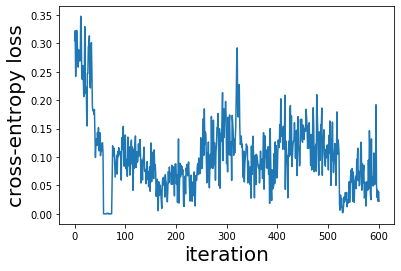

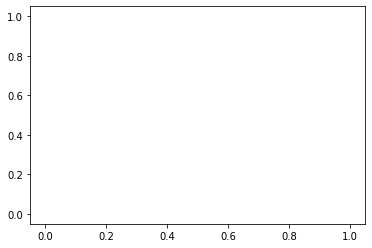

In [12]:
plt.figure()
plt.plot(range(len(history_trainingloss)), history_trainingloss)
plt.xlabel("iteration", fontsize=20)
plt.ylabel("cross-entropy loss", fontsize=20)
plt.show()
plt.figure()
plt.plot(range(len(history_testloss)), history_testloss)
plt.show()

In [13]:
print(model.size_output_stg2)
print(min(history_trainingloss))

[64, 200, 7, 7]
1.5330315e-05


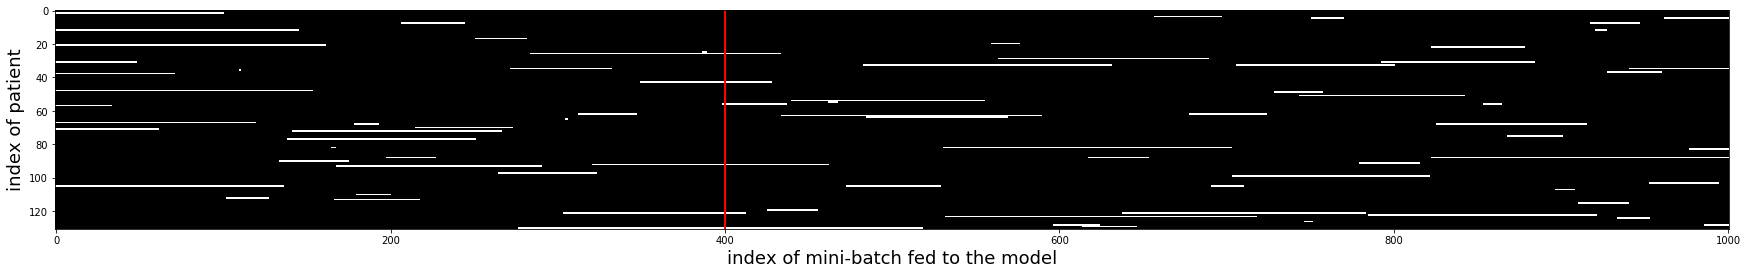

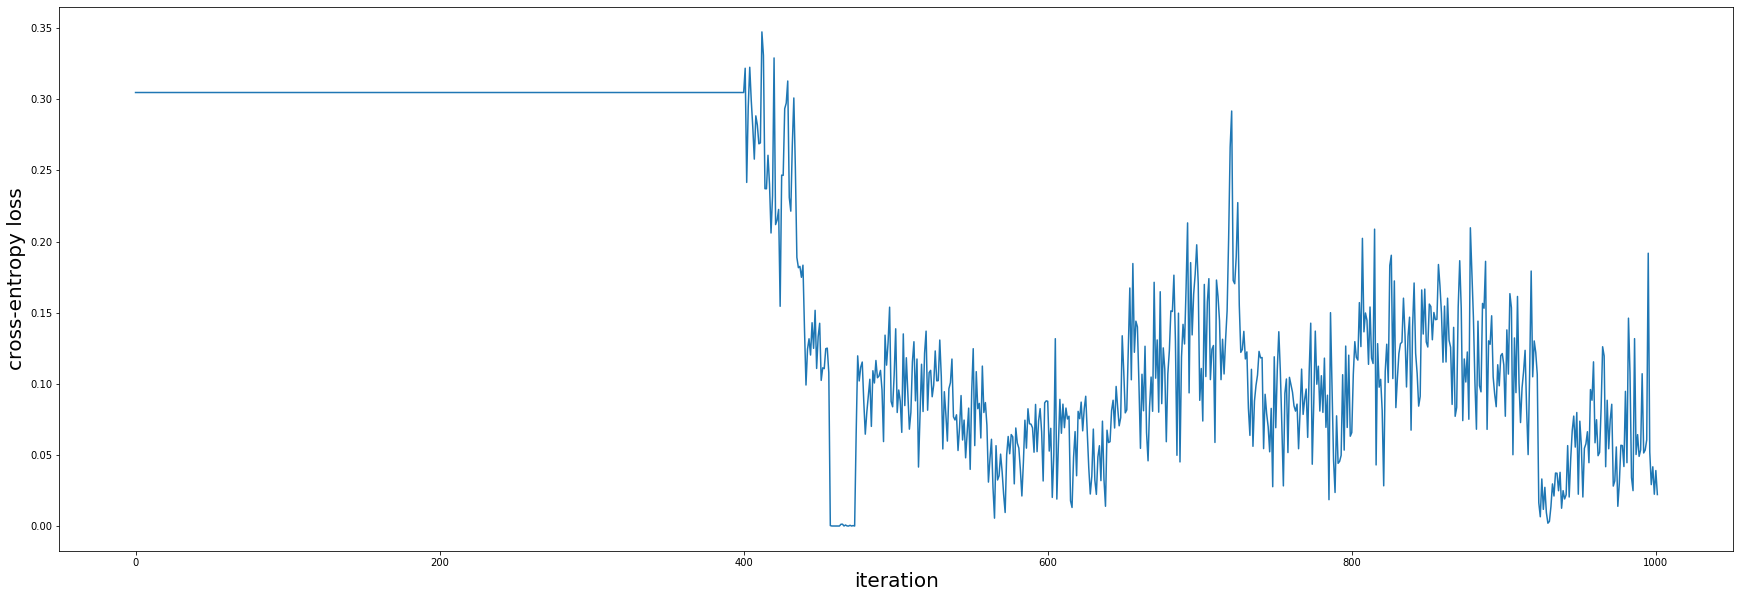

131 patients are present in the datset
   62.0 patients were seen during training.


In [14]:
def visualize_incommingpatches(input_dataset, list_seenbatches,\
                               history_trainingloss, num_warmup_droppedpatches):
    #make np_toshow =======
    np_toshow = np.zeros((len(input_dataset.list_patients), len(list_seenbatches) ))
    for idx_batch in range(len(list_seenbatches)):
        list_idx_patientsofbatch = [input_dataset.list_patients.index(patient)\
                                     for patient in list_seenbatches[idx_batch]]
        np_toshow[list_idx_patientsofbatch, idx_batch] = 1.0
    #show the assignments =========
    figsize=(30,10)
    plt.figure(figsize=figsize)
    plt.imshow(np_toshow, cmap="gray", vmin=0.0, vmax=1.0)
    plt.axvline(x=num_warmup_droppedpatches, color="r", linewidth=2)
    plt.ylabel("index of patient", fontsize=18)
    plt.xlabel("index of mini-batch fed to the model", fontsize=18)
    plt.show()
    #show the history of training loss ===
    plt.figure(figsize=figsize)
    plt.plot(range(len(history_trainingloss)+num_warmup_droppedpatches),\
             num_warmup_droppedpatches*[history_trainingloss[0]]+history_trainingloss)
    plt.xlabel("iteration", fontsize=20)
    plt.ylabel("cross-entropy loss", fontsize=20)
    plt.show()
    #report the unseen patients =====
    print("{} patients are present in the datset"\
           .format(len(input_dataset.list_patients)))
    print("   {} patients were seen during training."\
           .format(
                np.sum(
                    (np.sum(np_toshow,1)>0.0)+0.0
                )
            ))
visualize_incommingpatches(train_ds, list_seenbatches,\
                           history_trainingloss, num_warmup_droppedpatches)

/home/user1/anaconda3/envs/pyvipslocalbuild/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


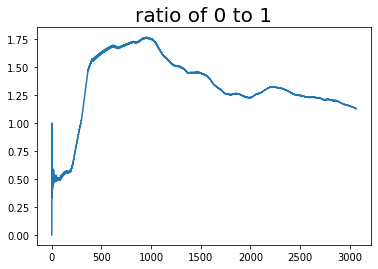

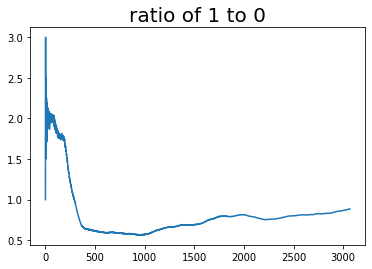

In [15]:
#check if the fed labels are balanced ===============
cum_0s = np.cumsum((np.array(history_fed_labels) == 0) + 0.0)
cum_1s = np.cumsum((np.array(history_fed_labels) == 1) + 0.0)
ratio_0to1 = cum_0s/cum_1s
ratio_1to0 = cum_1s/cum_0s
plt.figure()
plt.plot(range(ratio_0to1.shape[0]), ratio_0to1)
plt.title("ratio of 0 to 1", fontsize=20)
plt.show()
plt.figure()
plt.plot(range(ratio_1to0.shape[0]), ratio_1to0)
plt.title("ratio of 1 to 0", fontsize=20)
plt.show()


In [16]:
#save model and dataset ====================================
#delete the saved foreground maskes ===
for patient in recscore_dataset.list_patients:
    patient.dict_records["foreground_mask"] = []
#save
torch.save(model.state_dict(),\
        "Trained_Models/test_model.pt")
TODUMP = {}
TODUMP["train_ds"] = train_ds
TODUMP["val_ds"] = val_ds
TODUMP["test_ds"] = test_ds
TODUMP["recscore_dataset"] = recscore_dataset
TODUMP["batchsize"] = batchsize
TODUMP["num_visualwords"] = num_visualwords
pickle.dump(TODUMP,
            open(
                 "Trained_Models/test_dataset.pkl"\
                 .format(len(history_trainingloss), npseed), "wb"
              )
           )